In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function,division
from Pic.maxent_font import tick_font
# from Pic.maxent_style import maxent_style
from Utils.common.gridCV import gridCV
from Utils.qiancheng.get_data import read_data

/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
image_path = "/Users/chaoxu/code/local-spark/Data/image_qiancheng"
ratio = 0.05
model = 'rf'
version = '6v1.0sm'

In [3]:
df = read_data("/Users/chaoxu/code/local-spark/Data/qiancheng_data/qiancheng_sample_new_merge_{0}/data.csv".format(ratio))

In [4]:
import re
anormaly = re.compile('.*anomaly$')
anormaly_match = np.vectorize(lambda x:bool(anormaly.match(x)))
anormaly_cols = df.columns.values[anormaly_match(df.columns.values)]

value = re.compile('.*value$')
value_match = np.vectorize(lambda x:bool(value.match(x)))
value_cols = df.columns.values[value_match(df.columns.values)]

count = re.compile('.*counts$')
count_match = np.vectorize(lambda x:bool(count.match(x)))
count_cols = df.columns.values[count_match(df.columns.values)]

loan = re.compile('.*loan$')
loan_match = np.vectorize(lambda x:bool(loan.match(x)))
loan_cols = df.columns.values[loan_match(df.columns.values)]

In [5]:
# cols = df.columns
# fig, ax = plt.subplots(figsize=(16,9))
# ax.barh(range(len(cols)),df[cols].isnull().sum()/df.shape[0])
# ax.set_yticks(range(len(cols)))
# ax.set_yticklabels(cols, size=14)
# ax.set_title('features nan percentage',size= 18)
# plt.show()

In [6]:
df.select_dtypes(include=[np.object_]).columns

Index([u'maxent_id', u'os'], dtype='object')

整体的label平衡性

In [7]:
df.label.value_counts(normalize=True)

0    0.95
1    0.05
Name: label, dtype: float64

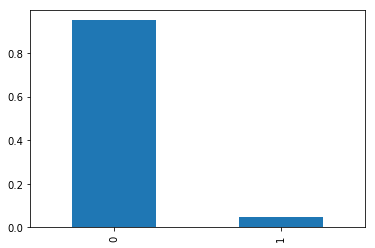

In [8]:
df.label.value_counts(normalize=True).plot(kind='bar')
plt.show()

In [9]:
obj_df = df.select_dtypes(include=['object'])
bool_df = df.select_dtypes(include=['bool'])
obj_cols = obj_df.columns.values.tolist()
# obj_cols.remove('event_id')
print(obj_cols)
bool_cols = bool_df.columns.values.tolist()
print(bool_cols)
encoder_cols = obj_cols
if 'maxent_id' in encoder_cols:
    encoder_cols.remove('maxent_id')
print(encoder_cols)

['maxent_id', 'os']
['cracked.value', 'idcIP.value']
['os']


In [10]:
df_ios = df.loc[df.os == 'ios']

In [11]:
from sklearn.preprocessing import LabelEncoder
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [12]:
df_ios = MultiColumnLabelEncoder(columns = encoder_cols).fit_transform(df_ios)

In [13]:
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing
df_ios[show_missing()].isnull().sum()

Series([], dtype: float64)

In [14]:
ios_drop = ['os','maxent_id','aid_loan','imei_loan','mac_loan','imei_counts','mac_counts','aid_counts']
df_ios=df_ios.drop(ios_drop,axis=1)

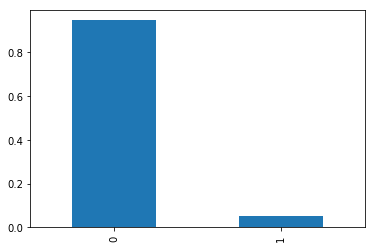

In [15]:
df_ios.label.value_counts(normalize=True).plot(kind='bar')

save_path = image_path + "/ios_label_ratio-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [16]:
from Utils.common.splitData import splitData

df_ios_train, df_ios_test = splitData(df_ios,0.7)
# df_ios_maxent_id = df_ios_test['maxent_id'].reset_index(drop=True)
X_ios_train = df_ios_train.ix[:, df_ios_train.columns != 'label']
X_ios_test  = df_ios_test.ix[:, df_ios_test.columns != 'label']
y_ios_train = df_ios_train.ix[:, df_ios_train.columns == 'label']
y_ios_test  = df_ios_test.ix[:, df_ios_test.columns == 'label']
print("Number transactions ios train dataset: ", X_ios_train.shape)
print("Number transactions ios train dataset: ", y_ios_train.shape)
print("Number transactions ios test dataset: ", X_ios_test.shape)
print("Total number of ios transactions: ", X_ios_train.size)

Number transactions ios train dataset:  (2096, 67)
Number transactions ios train dataset:  (2096, 1)
Number transactions ios test dataset:  (900, 67)
Total number of ios transactions:  140432


In [17]:
from __future__ import print_function,division
import itertools
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('label 1')
    plt.xlabel('label 0')

In [18]:
def get_ios_group_label(row):
#     print(row['y_ios_test'].values)
#     if row['y_ios_test'].values[0] == 1:
    return row['y_ios_pred'].max()
#     else:
#         return row['y_ios_pred'].min()

In [19]:
from sklearn import tree
from IPython.display import Image
import pydotplus
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

In [20]:
from Params.cv_params import cv_params
from Params.rf_params import rf_test_params as all_test_params
from Params.rf_params import rf_base_params as tree_base_params
params_ios = {}
params_ios.update(tree_base_params)
params_ios

{'class_weight': 'balanced',
 'criterion': 'gini',
 'n_jobs': -1,
 'random_state': 42}

In [21]:
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,precision_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image
import pydotplus
# X_ios_cols = X_ios_train.columns
X_ios_train_cv = X_ios_train
y_ios_train_cv = y_ios_train['label']
ios_params,_clf = gridCV(clf=RandomForestClassifier,X=X_ios_train_cv,y=y_ios_train_cv,
                         base_params=tree_base_params,all_test_params=all_test_params,cv_parmas=cv_params)

clf_ios = RandomForestClassifier(**ios_params)
clf_0 = clf_ios.fit(X_ios_train, y_ios_train)

get best parameters is {'n_jobs': -1, 'min_impurity_decrease': 0.02, 'max_leaf_nodes': 6, 'min_samples_leaf': 70, 'n_estimators': 20, 'max_features': None, 'random_state': 42, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 4, 'class_weight': 'balanced'}


In [22]:
X_ios_train.shape

(2096, 67)

Recall metric in the testing dataset:  0.354166666667
Precision metric in the testting dataset: 0.0858585858586
f2 metric in the testting dataset: 4.58823529412
             precision    recall  f1-score   support

          0       0.96      0.79      0.86       852
          1       0.09      0.35      0.14        48

avg / total       0.91      0.76      0.82       900



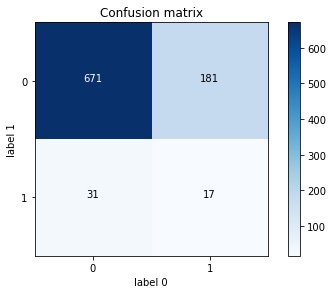

In [23]:
y_ios_pred = clf_0.predict(X_ios_test)

cnf_matrix = confusion_matrix(y_ios_test,y_ios_pred)
np.set_printoptions(precision=2)
np.set_printoptions(precision=2)
recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
precision = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
f2 = 0.2*(4/recall + 1/precision)
print("Recall metric in the testing dataset: ", recall)
print("Precision metric in the testting dataset:", precision)
print("f2 metric in the testting dataset:", f2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')

print(classification_report(y_ios_test, y_ios_pred, target_names=['0','1']))
save_path = image_path + "/tree_ios_conf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

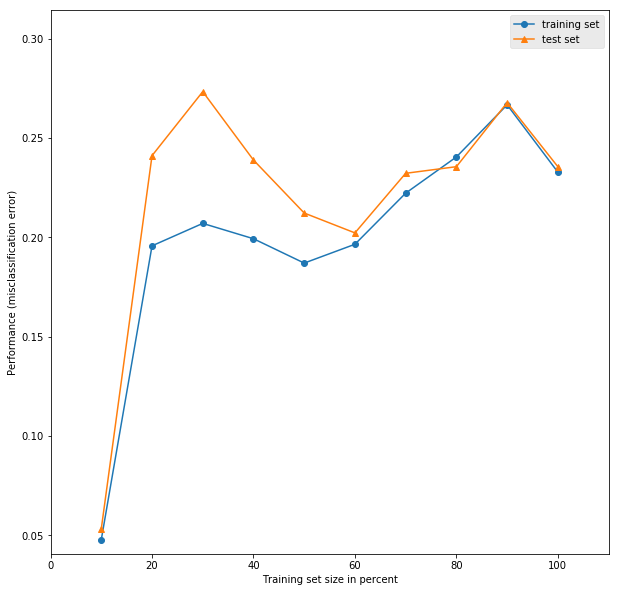

In [24]:
from mlxtend.plotting import plot_learning_curves
y_ios_train_f = y_ios_train.label.astype(float)
y_ios_test_f = y_ios_test.label.astype(float)
fig,ax= plt.subplots(figsize=(10,10))
ax.grid(b=False)
plot_learning_curves(X_ios_train, y_ios_train_f, X_ios_test, y_ios_test_f, clf_0, print_model=False,style='ggplot')

save_path = image_path + "/ios_learning_perf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

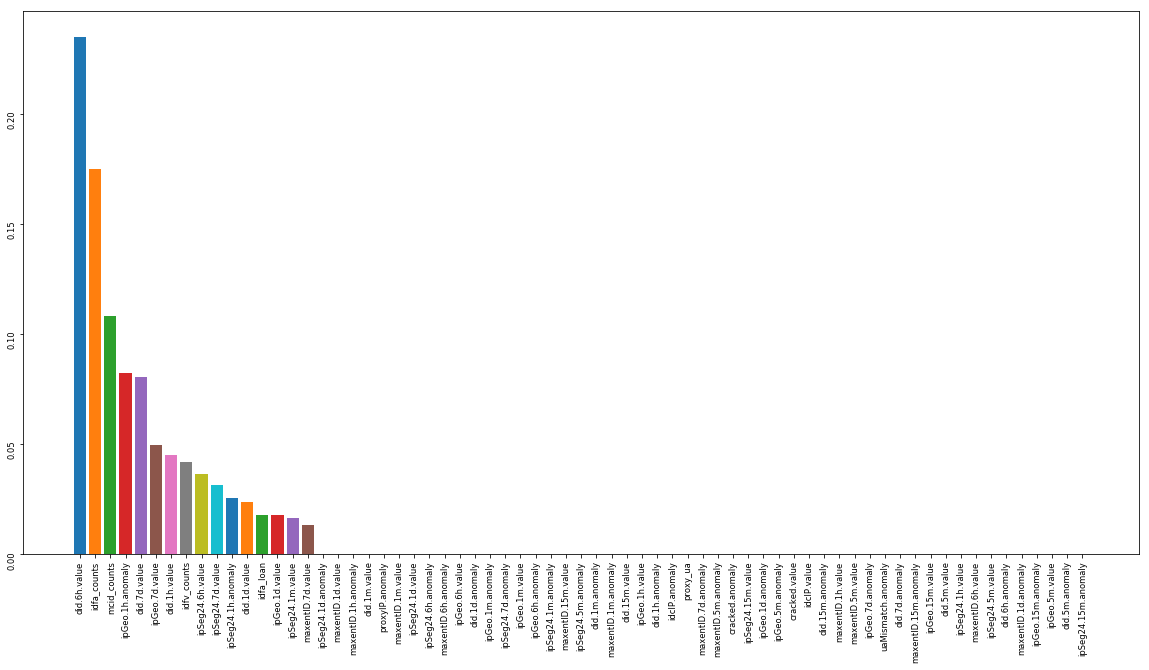

In [25]:
df_feature_ios = pd.DataFrame(X_ios_train.columns.values,columns=['column'])
df_importance = pd.DataFrame(clf_0.feature_importances_,columns=['feature importances'])
df_ios_fim = pd.concat([df_feature_ios,df_importance],axis=1)
fig,ax= plt.subplots(figsize=(20,10))
df_ios_fim=df_ios_fim.sort(['feature importances'],ascending=False)
for x, y in enumerate(df_ios_fim['feature importances'].values):
    ax.bar(x, y)
x_labels = df_ios_fim['column'].values
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
tick_font(ax,font_size="small",rotation=90)

save_path = image_path + "/ios_feature_importance-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [26]:
df_android = df.loc[df.os == 'android']
df_android = MultiColumnLabelEncoder(columns = encoder_cols).fit_transform(df_android)

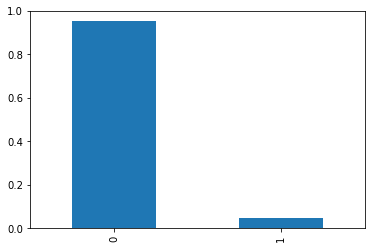

In [27]:
df_android.label.value_counts(normalize=True).plot(kind='bar')

save_path = image_path + "/android_label_ratio-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

In [28]:
df_android[show_missing()].isnull().sum()

Series([], dtype: float64)

In [29]:
android_drop = ['os','maxent_id','idfa_loan','idfa_counts', u'idfv_counts','imei_loan']
df_android =df_android.drop(android_drop,axis=1)

In [30]:
df_android_train, df_android_test = splitData(df_android,0.7)
X_android_train = df_android_train.ix[:, df_android_train.columns != 'label']
X_android_test  = df_android_test.ix[:, df_android_test.columns != 'label']
y_android_train = df_android_train.ix[:, df_android_train.columns == 'label']
y_android_test  = df_android_test.ix[:, df_android_test.columns == 'label']
print("Number transactions android train dataset: ", X_android_train.shape[0])
print("Number transactions android train dataset: ", y_android_train.shape[0])
print("Number transactions android test dataset: ", X_android_test.shape[0])
print("Total number of android transactions: ", X_android_train.size)

Number transactions android train dataset:  4370
Number transactions android train dataset:  4370
Number transactions android test dataset:  1874
Total number of android transactions:  301530


In [31]:
params_android = {}
params_android.update(tree_base_params)
params_android

{'class_weight': 'balanced',
 'criterion': 'gini',
 'n_jobs': -1,
 'random_state': 42}

In [32]:
X_android_train_cv = X_android_train
y_android_train_cv = y_android_train['label']
android_params,_clf = gridCV(clf=RandomForestClassifier,X=X_android_train_cv,y=y_android_train_cv,
                         base_params=tree_base_params,all_test_params=all_test_params,cv_parmas=cv_params)

clf_android = RandomForestClassifier(**android_params)
clf_1 = clf_android.fit(X_android_train, y_android_train)

get best parameters is {'n_jobs': -1, 'min_impurity_decrease': 0.01, 'max_leaf_nodes': 6, 'min_samples_leaf': 70, 'n_estimators': 18, 'max_features': 'sqrt', 'random_state': 42, 'criterion': 'gini', 'min_samples_split': 50, 'max_depth': 4, 'class_weight': 'balanced'}


In [33]:
def get_android_group_label(row):
#     if row['y_android_test'].values[0] == 1:
    return row['y_android_pred'].max()
#     else:
#         return row['y_android_pred'].min()


Recall metric in the testing dataset:  0.527472527473
Precision metric in the testting dataset: 0.0690647482014
f2 metric in the testting dataset: 4.4125
             precision    recall  f1-score   support

          0       0.96      0.64      0.77      1783
          1       0.07      0.53      0.12        91

avg / total       0.92      0.63      0.74      1874



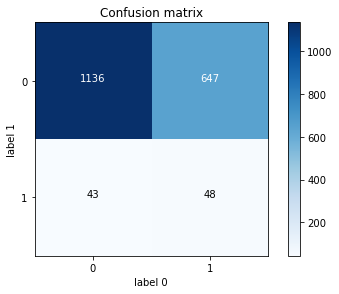

In [34]:
y_android_pred = clf_1.predict(X_android_test)

cnf_matrix = confusion_matrix(y_android_test,y_android_pred)
np.set_printoptions(precision=2)
np.set_printoptions(precision=2)
recall = cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
precision = cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
f2 = 0.2*(4/recall + 1/precision)
print("Recall metric in the testing dataset: ", recall)
print("Precision metric in the testting dataset:", precision)
print("f2 metric in the testting dataset:", f2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')

print(classification_report(y_android_test, y_android_pred, target_names=['0','1']))
save_path = image_path + "/tree_android_conf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

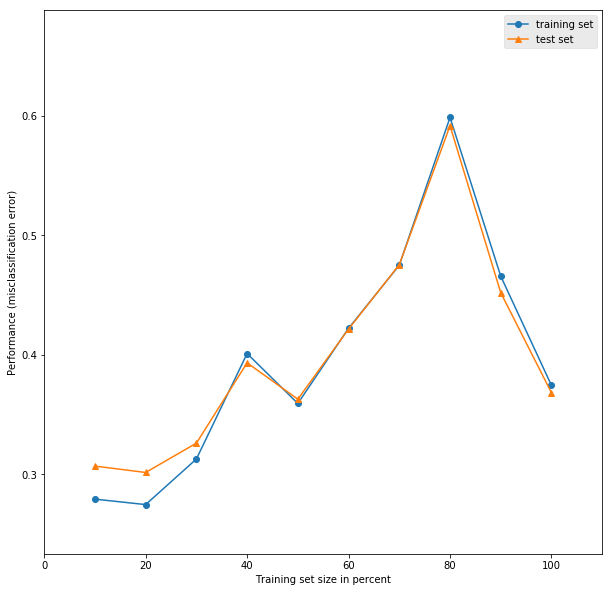

In [35]:
from mlxtend.plotting import plot_learning_curves
y_android_train_f = y_android_train.label.astype(float)
y_android_test_f = y_android_test.label.astype(float)
fig,ax= plt.subplots(figsize=(10,10))
ax.grid(b=False)
plot_learning_curves(X_android_train, y_android_train_f, X_android_test, y_android_test_f, clf_1, print_model=False,style='ggplot')

save_path = image_path + "/android_learning_perf-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()

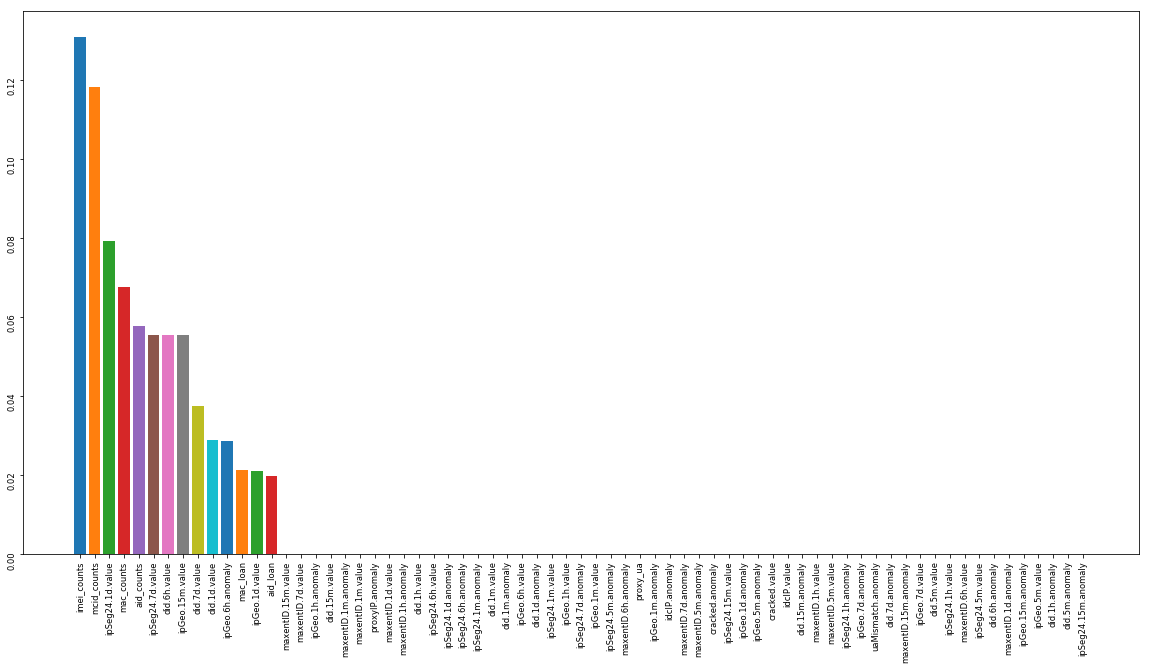

In [36]:
df_feature_android = pd.DataFrame(X_android_train.columns.values,columns=['column'])
df_android_importance = pd.DataFrame(clf_1.feature_importances_,columns=['feature importances'])
df_android_fim = pd.concat([df_feature_android,df_android_importance],axis=1)
fig,ax= plt.subplots(figsize=(20,10))
df_android_fim=df_android_fim.sort(['feature importances'],ascending=False)
for x, y in enumerate(df_android_fim['feature importances'].values):
    ax.bar(x, y)
x_labels = df_android_fim['column'].values
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)
tick_font(ax,font_size="small",rotation=90)

save_path = image_path + "/android_feature_importance-{0}-{1}-{2}.png".format(version,ratio,model)
fig = plt.gcf()
fig.savefig(save_path,format='png')
plt.show()